In [1]:
!pip install -q datasets transformers evaluate timm albumentations
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/


In [1]:
from huggingface_hub import notebook_login

# Use WRITE TOKEN!

notebook_login()

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__, 
    "; supervision:", supervision.__version__, 
    "; transformers:", transformers.__version__, 
    "; pytorch_lightning:", pytorch_lightning.__version__
)

import gc
torch.cuda.empty_cache()
gc.collect()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  2.1 ; cuda:  cu121
roboflow: 1.1.9 ; supervision: 0.3.0 ; transformers: 4.35.2 ; pytorch_lightning: 2.1.2


1152

In [3]:
import torch
from transformers import DetaConfig, DetaModel
from transformers import AutoImageProcessor, DetaForObjectDetection
from PIL import Image
import requests

# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT="jozhang97/deta-resnet-50-24-epochs"
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = AutoImageProcessor.from_pretrained(CHECKPOINT)
model = DetaForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)


2023-12-05 11:15:17.505719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 11:15:17.505758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


DetaForObjectDetection(
  (model): DetaModel(
    (backbone): DetaBackboneWithPositionalEncodings(
      (model): ResNetBackbone(
        (embedder): ResNetEmbeddings(
          (embedder): ResNetConvLayer(
            (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (normalization): DetaFrozenBatchNorm2d()
            (activation): ReLU()
          )
          (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (encoder): ResNetEncoder(
          (stages): ModuleList(
            (0): ResNetStage(
              (layers): Sequential(
                (0): ResNetBottleNeckLayer(
                  (shortcut): ResNetShortCut(
                    (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (normalization): DetaFrozenBatchNorm2d()
                  )
                  (layer): Sequential(
                    (0): ResNetConvLayer(
    

In [4]:
import os
import torchvision

dataset_location = './Stone_segmentation-3'

# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset_location, "train")
VAL_DIRECTORY = os.path.join(dataset_location, "valid")
TEST_DIRECTORY = os.path.join(dataset_location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False)


#TEST_DATASET = CocoDetection(
#    image_directory_path=TEST_DIRECTORY, 
#    image_processor=image_processor, 
#    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
#print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 100
Number of validation examples: 34



## Visualize data entry

#### NOTE: Feel free to reload this cell multiple times. Notebook should display different train set image each time.


Image #93


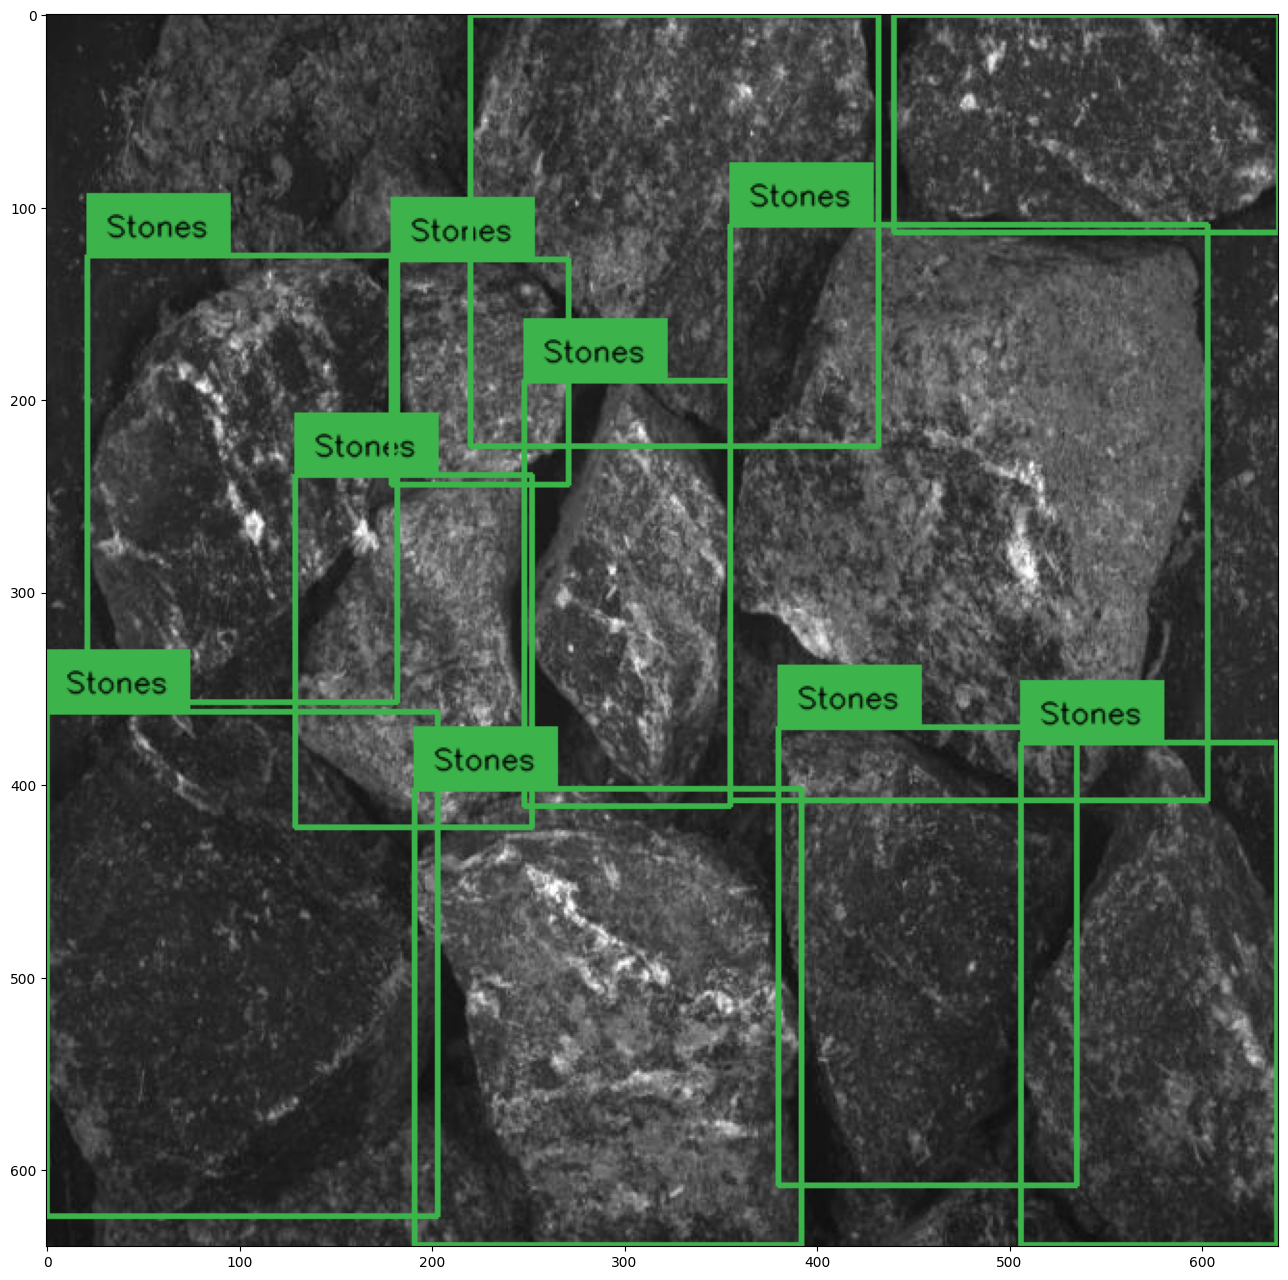

In [5]:
import random
import cv2
import numpy as np
import supervision as sv

# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)
    
#mask_annotator = sv.MaskAnnotator()
#frame = mask_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))

In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
#TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

TEST_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)

In [11]:
import pytorch_lightning as pl
from transformers import DetaForObjectDetection
import torch

class Deta(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetaForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        
        self.log("training_loss", loss, batch_size=2)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item(), batch_size=2)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss, batch_size=2)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item(), batch_size=2)
            
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [8]:
model = Deta(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50-24-epochs and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- mode

In [9]:
outputs.logits.shape

torch.Size([4, 300, 2])

In [10]:
from pytorch_lightning import Trainer

%cd {HOME}

# settings
MAX_EPOCHS = 24

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

using bookmarks requires you to install the `pickleshare` library.
GPU available: True (cuda), used: True


[Errno 2] No such file or directory: '{HOME}'
/wdata/Project_Practicum/URFU_project/huggingface_DETA


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetaForObjectDetection | 48.3 M
-------------------------------------------------
48.1 M    Trainable params
222 K     Non-trainable params
48.3 M    Total params
193.114   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/a8/python_venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.
/home/a8/python_venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/a8/python_venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/a8/python_venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=24` reached.


In [ ]:
model.to(DEVICE)

In [ ]:
import random
import cv2
import numpy as np

### DBG!!CHANGE TO REAL!!!
TEST_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False)

categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))